<h1 align="center"> 
  Air Quality
</h1>

<h4 align="center">
    <img alt="AirQuality" title="#AirQuality" src="https://www.healthissuesindia.com/wp-content/uploads/2020/02/81287396_l-2048x1365.jpg" width="400px;" />
</h4>

## 🔍 About

The following program intends to predict air quality based on the amount of carbon monoxide. This problem purpose by professor Diego Furtado in the discipline of Machine Learning aims to solve a known problem using linear regression methods. In sequence, we'll analyze some approaches to tackle this problem by predicting the quantity of carbon dioxide in the air.

In this [link](https://archive.ics.uci.edu/ml/datasets/Air+Quality), you can locate the dataset that was used. We also made a jupyter notebook available for a better comprehension of the topic.

## 🦸 Authors
- Felipe Tavoni
- Reynold N. Mazo


# **Importing Libraries and Downloading Dataset**

In [ ]:
import os
import math
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import date
from sklearn import metrics
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVR
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
!gdown --id 1IaXfQ_EYlm7ylKyfjSpYlSywTuNrPygE

Downloading...
From: https://drive.google.com/uc?id=1IaXfQ_EYlm7ylKyfjSpYlSywTuNrPygE
To: /content/AirQualityUCI.csv
100% 785k/785k [00:00<00:00, 12.3MB/s]


In [ ]:
# !gdown --id 10eGpY7tUoS1REwPG1eazWFxb1ADDL2Ez TESTE USANDO MEU CSV COM NOUN 

---
# **Exploratory Data Analysis**

## Missing values

> First, we need to check how many values are missing in our dataset. This wil help us out to choose the best approach on data.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

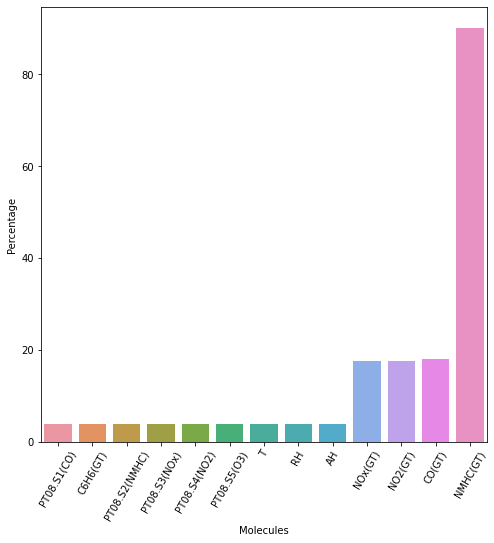

In [ ]:
# Reading .csv
air_quality = pd.read_csv('AirQualityUCI.csv', delimiter=';')

# Removing 2 last columns that does not exist. Removing last 114 lines (does not cantain data).
air_quality = air_quality.iloc[:9356, :-2]

# Transform -200 to NaN for better usage on pandas tools.
air_quality.replace(to_replace=-200, value=np.nan, inplace=True)
missing_values = air_quality.isna().sum() / len(air_quality)
# Removing those that don't have missing data.
missing_values = missing_values[missing_values > 0] * 100
missing_values.sort_values(inplace=True)

# Mapping the Series to a DataFrame, for a better plotting.
missing_values = missing_values.to_frame()
missing_values.columns = ['Percentage']
# missing_values.index.names = ['Molecules']
missing_values['Molecules'] = missing_values.index

plt.figure(figsize=(8,8))
sns.barplot(x = 'Molecules', y = 'Percentage', data=missing_values)
plt.xticks(rotation = 60)

> So, we can observe that NHMC(GT) have more of 90% of your data missing. Therefore, we need to adopt some strategy to get through this problem.

> First, for those values that have less than 20% of your data missing, a imputation strategy might be enough. On the other hand, for the NHMC(GT) feature, the best solution is to drop the column, since we have so less data than other, it's not viable to use it.


In [ ]:
# Drop `NHMC(GT)` column.
air_quality.drop(['NMHC(GT)'], axis=1, inplace=True)

# Imputing values for the other columns, previously defined.
# As the imputation strategy, we'll simply fill NaN with the mean of all other values.
for column in air_quality:
  if column == 'Date' or column == 'Time':
    continue
  air_quality[column].fillna(air_quality[column].mean(), inplace = True)

print(air_quality)

            Date      Time  CO(GT)  ...     T    RH      AH
0     10/03/2004  18.00.00     2.6  ...  13.6  48.9  0.7578
1     10/03/2004  19.00.00     2.0  ...  13.3  47.7  0.7255
2     10/03/2004  20.00.00     2.2  ...  11.9  54.0  0.7502
3     10/03/2004  21.00.00     2.2  ...  11.0  60.0  0.7867
4     10/03/2004  22.00.00     1.6  ...  11.2  59.6  0.7888
...          ...       ...     ...  ...   ...   ...     ...
9351  04/04/2005  09.00.00     3.9  ...  18.2  36.3  0.7487
9352  04/04/2005  10.00.00     3.1  ...  21.9  29.3  0.7568
9353  04/04/2005  11.00.00     2.4  ...  24.3  23.7  0.7119
9354  04/04/2005  12.00.00     2.4  ...  26.9  18.3  0.6406
9355  04/04/2005  13.00.00     2.1  ...  28.3  13.5  0.5139

[9356 rows x 14 columns]


---
## Day and time
Due to the continuous variables present in a linear regression model, we have to discretize the *day* and *time* features and also analyze if there's any connection with other variables.

In [ ]:
# air_quality.rename(columns = {'0Date': 'Date'}, inplace = True) UTILIZADO PARA O CASO DO MEU DATASET

# Converting date of type string to Timestamp
air_quality['Date'] = pd.to_datetime(arg=air_quality['Date'], format = "%d/%m/%Y", exact = True)
# Now 'rreconvert' and create comlumn 'month', as datatype 'date'
air_quality['Month'] = air_quality['Date'].dt.month
air_quality['Date'] = air_quality['Date'].dt.date 

# Obtaining the they of the week, based on the date.
for index in air_quality.index:
  air_quality.at[index, 'Day'] = date.fromisoformat(str(air_quality['Date'].iloc[index])).weekday()

# Remmaping values, from integers to string
air_quality['Day'] = air_quality['Day'].map({0: "Domingo", 1: "Segunda", 2: "Terca", 
                                              3:"Quarta" , 4: "Quinta", 5: "Sexta", 6:"Sabado"})

air_quality['Month'] = air_quality['Month'].map({
                                                  1: "Janeiro", 2: "Fevereiro", 3: "Marco", 
                                                  4: "Abril", 5: "Maio", 6:"Junho", 7:"Julho", 8:"Agosto", 9: "Setembro",
                                                  10:"Setembro", 11:"Outubro", 12:"Dezembro"
                                                  })

# air_quality['CO(GT)'] = float()
# air_quality["CO(GT)"] = air_quality["CO(GT)"].map({
#                                                   "None": float(air_quality["CO(GT)"].mean(skipna = True))

# })
air_quality

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Month,Day
0,2004-03-10,18.00.00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,Marco,Terca
1,2004-03-10,19.00.00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,Marco,Terca
2,2004-03-10,20.00.00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,Marco,Terca
3,2004-03-10,21.00.00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,Marco,Terca
4,2004-03-10,22.00.00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,Marco,Terca
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9351,2005-04-04,09.00.00,3.9,1297.0,13.6,1102.0,523.0,507.0,187.0,1375.0,1583.0,18.2,36.3,0.7487,Abril,Domingo
9352,2005-04-04,10.00.00,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,Abril,Domingo
9353,2005-04-04,11.00.00,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,Abril,Domingo
9354,2005-04-04,12.00.00,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,Abril,Domingo


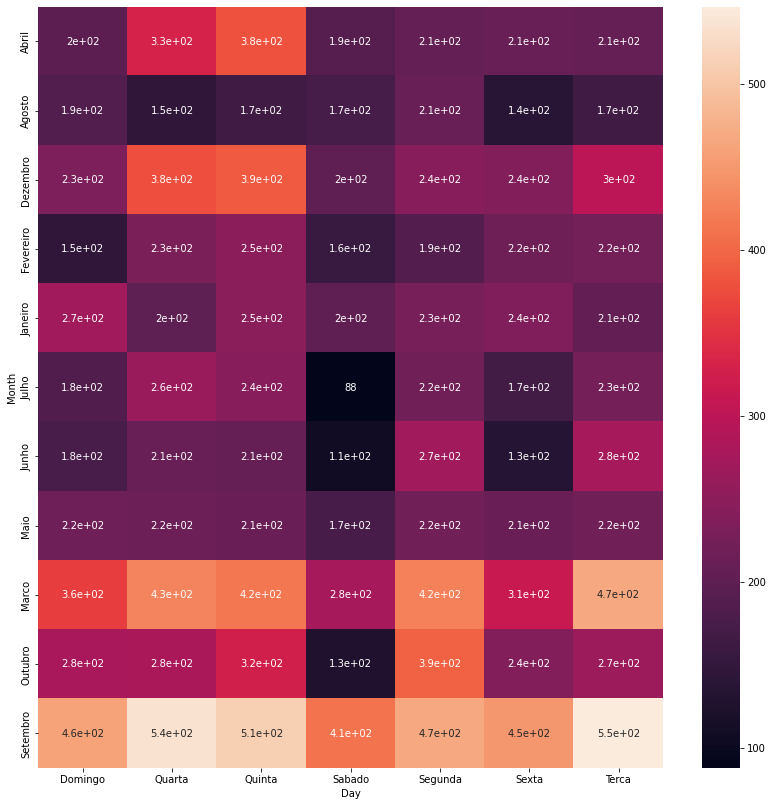

In [ ]:
plt.figure(figsize=(14,14))
baloon = air_quality.pivot_table(columns="Day", index="Month", values="CO(GT)", aggfunc="sum").fillna(0)
# baloon = baloon.reindex(months)
sns.heatmap(baloon, annot=True);

---
## Correlation Between Features

> Now, we can analyse the iteraction between each features. Though a *confusion* matrix, we can observe, by calculating cross correlation, how features behave by interacting with each other.

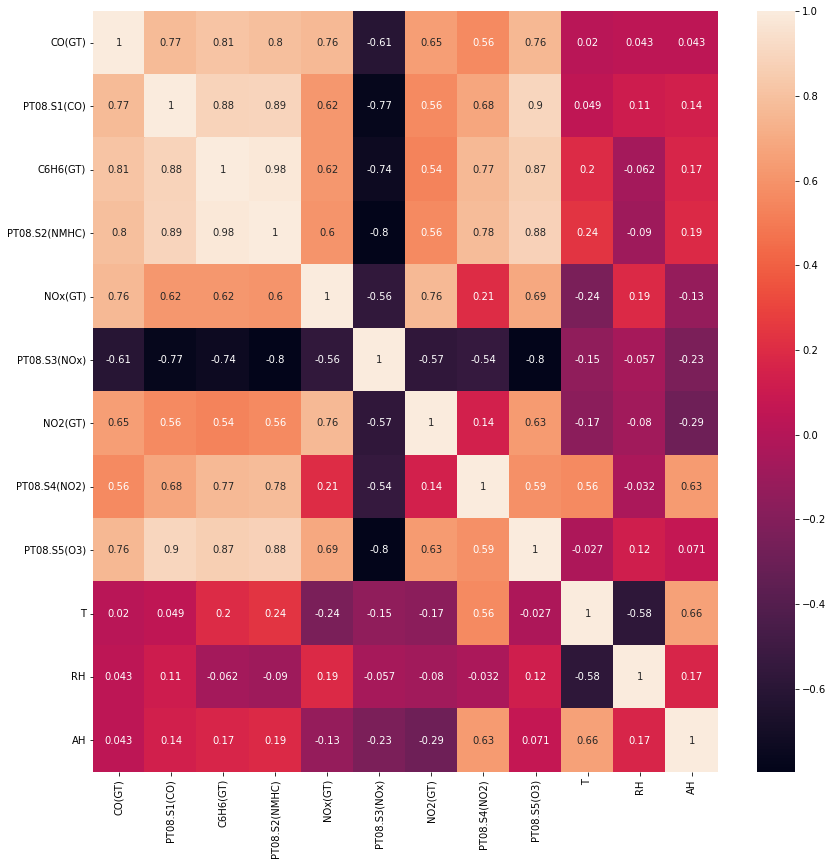

In [ ]:
plt.figure(figsize=(14,14))
# Checking correlation between all features
sns.heatmap(air_quality.corr(), annot=True);

> And yet for a better visualization, we can observe the function behavior on graphics. There's ome annomalies on the graphics, due to our imputation scheme, proposed above.

<Figure size 792x792 with 0 Axes>

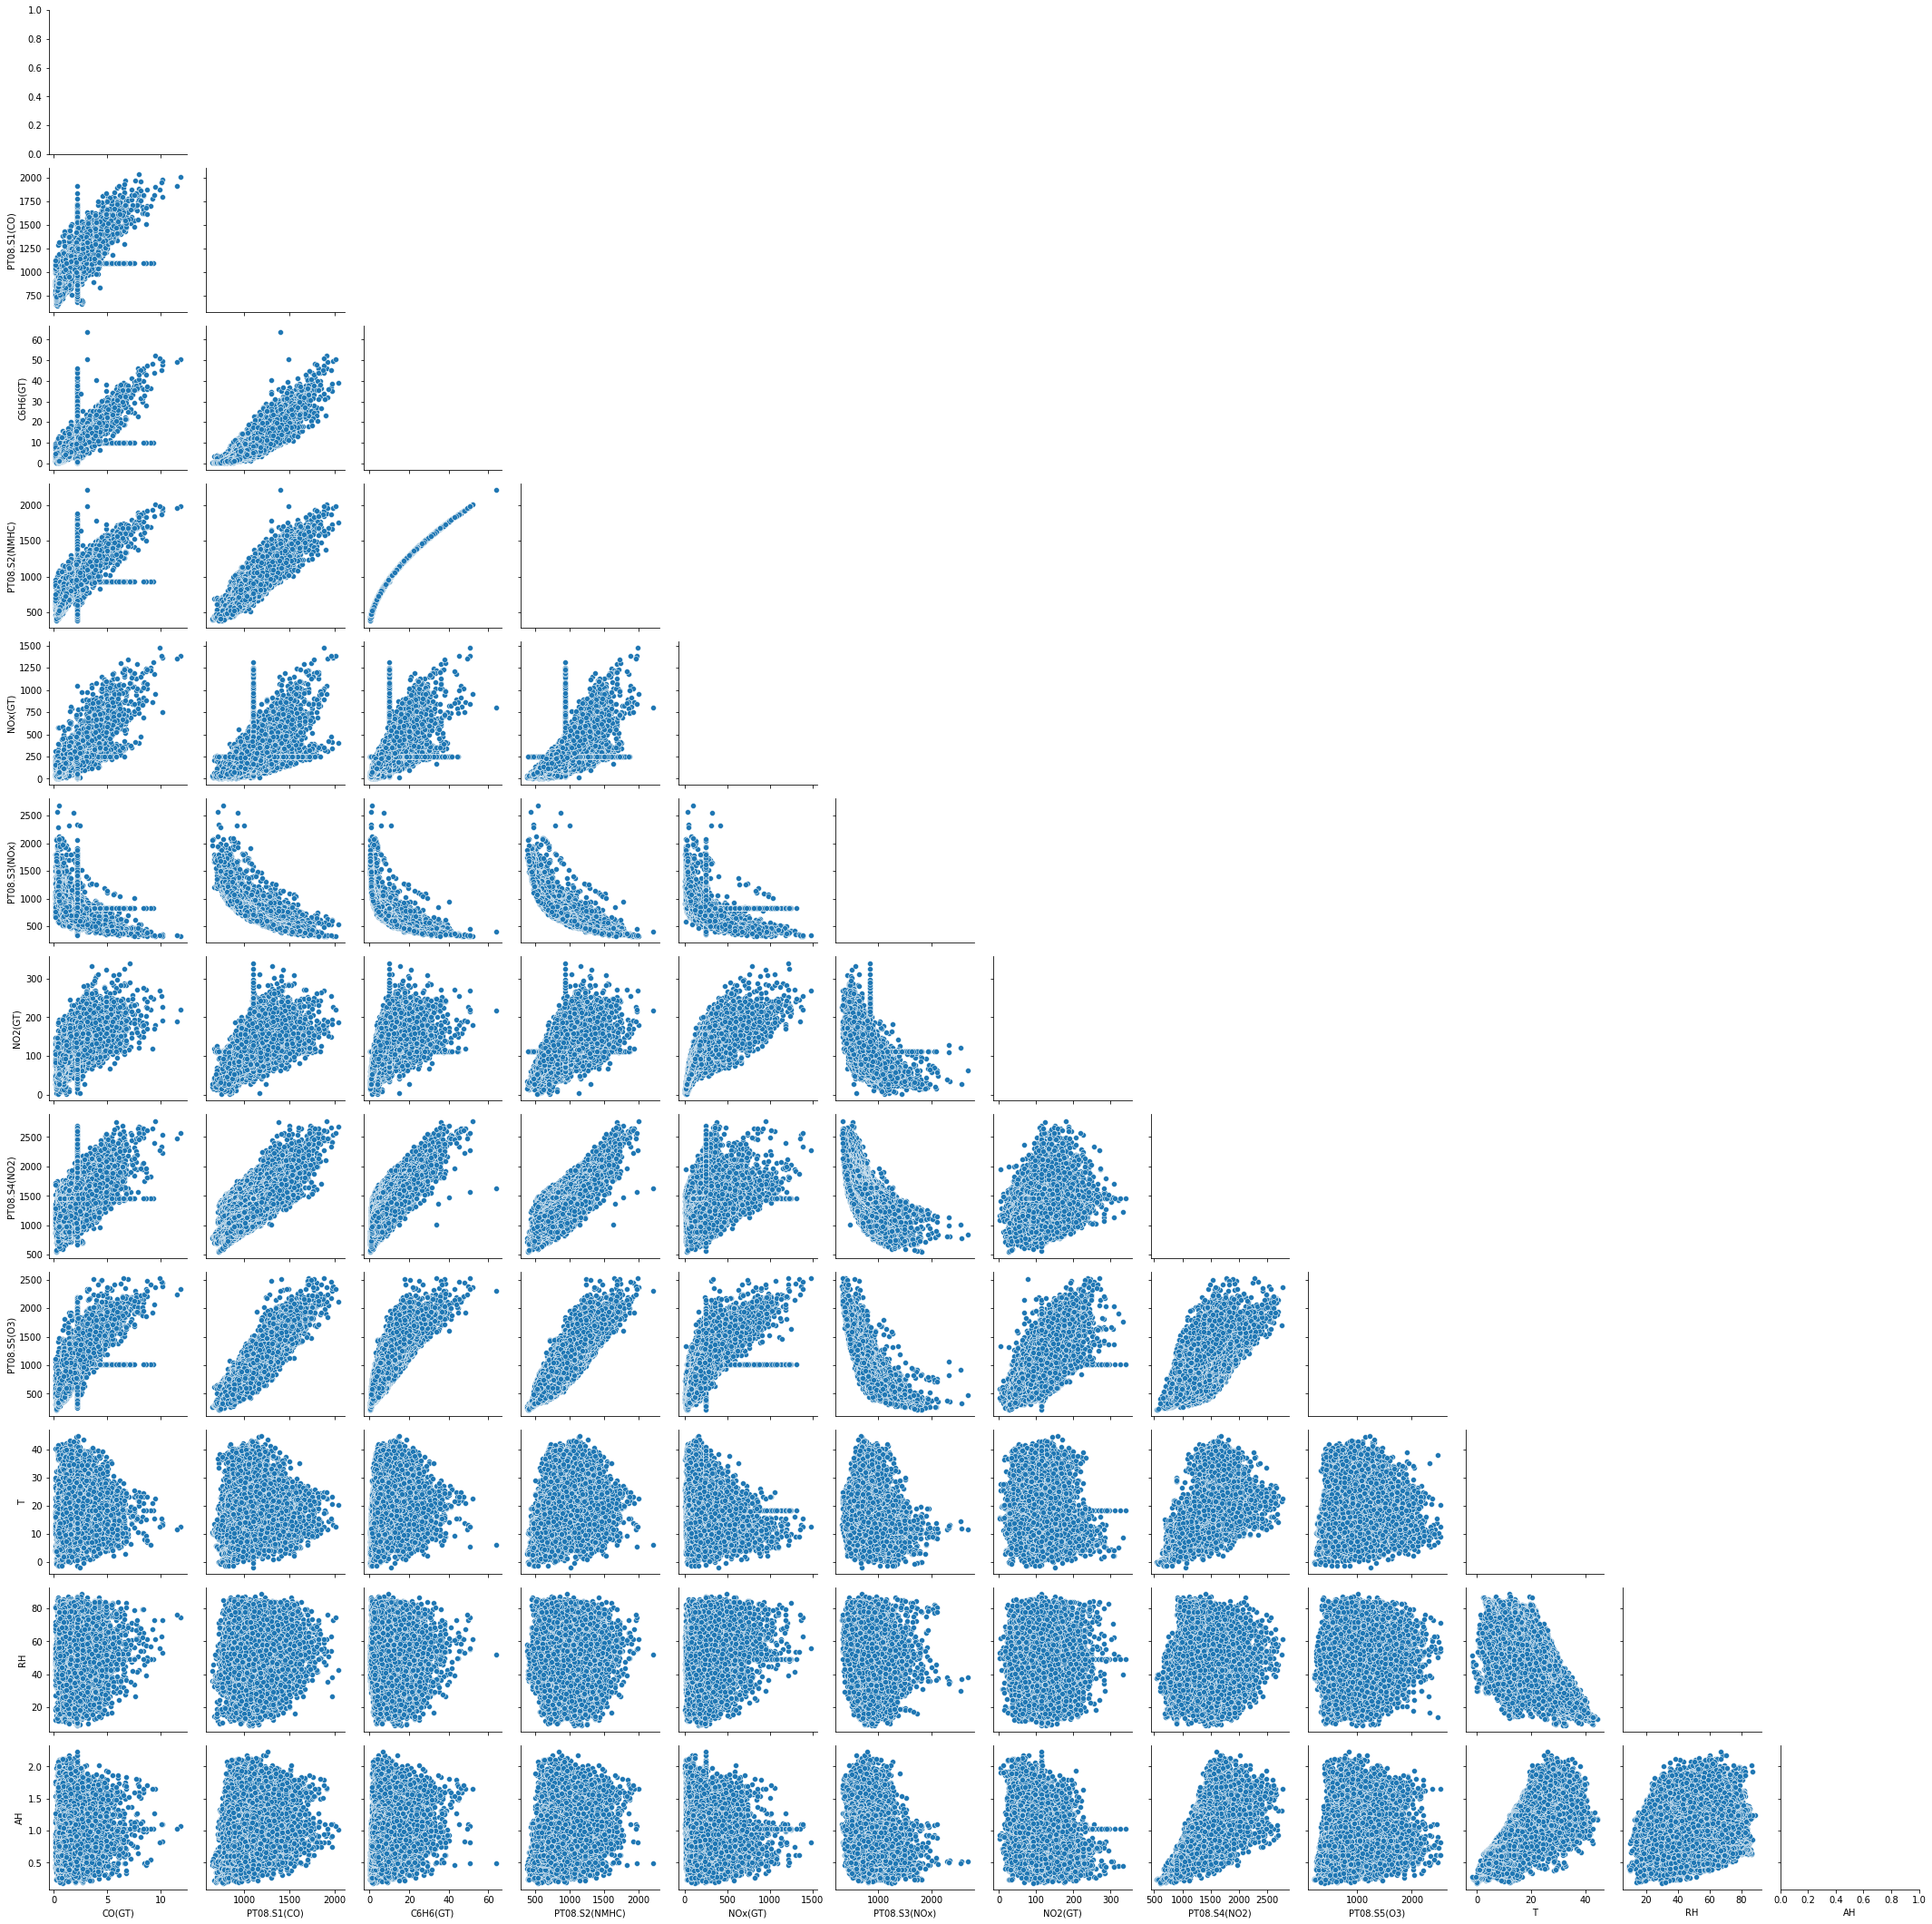

In [ ]:
# Ploting all data
plt.figure(figsize=(11,11))
g = sns.PairGrid(air_quality, diag_sharey=False, corner=True)
g.map_lower(sns.scatterplot)

---
# **The Regression Models**

## Selecting The Features To Use On Our Regression Model - CO(GT)

> So, with the analisys based on our correlation matrix, we will build our regression model to predict the CO(GT) feature based on the following attributes:
*PT08.S1(CO), PT08.S2(NMHC), C6H6(GT), NOx(GT), NO2(GT), PT08.S5(O3)*.


In [ ]:
# Parsing the attributes based on highest correlation (O3, NO2, NHMC). Dropping those that will not be used.
x_air_quality_attributes = air_quality[['PT08.S1(CO)', 'PT08.S2(NMHC)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)', 'PT08.S5(O3)']]
# x_air_quality_attributes = x_air_quality_attributes.apply(pd.to_numeric, errors='coerce')
print(x_air_quality_attributes)
y_air_quality_attributes = air_quality['CO(GT)'].to_frame()
# pd.DataFrame(y_air_quality_attributes, columns='CO(GT)')
print(y_air_quality_attributes['CO(GT)'])

      PT08.S1(CO)  PT08.S2(NMHC)  C6H6(GT)  NOx(GT)  NO2(GT)  PT08.S5(O3)
0          1360.0         1046.0      11.9    166.0    113.0       1268.0
1          1292.0          955.0       9.4    103.0     92.0        972.0
2          1402.0          939.0       9.0    131.0    114.0       1074.0
3          1376.0          948.0       9.2    172.0    122.0       1203.0
4          1272.0          836.0       6.5    131.0    116.0       1110.0
...           ...            ...       ...      ...      ...          ...
9351       1297.0         1102.0      13.6    523.0    187.0       1583.0
9352       1314.0         1101.0      13.5    472.0    190.0       1729.0
9353       1163.0         1027.0      11.4    353.0    179.0       1269.0
9354       1142.0         1063.0      12.4    293.0    175.0       1092.0
9355       1003.0          961.0       9.5    235.0    156.0        770.0

[9356 rows x 6 columns]
0       2.6
1       2.0
2       2.2
3       2.2
4       1.6
       ... 
9351    3.9
935

## Training, Testing and Evaluating: **Linear Regression**

### Training

In [ ]:
# Spliting test data
x_air_quality_training, x_air_quality_test, y_air_quality_training, y_air_quality_test = train_test_split(x_air_quality_attributes, y_air_quality_attributes, test_size = 0.3, random_state = 49)

# Instantiating the regressor
linearRegressor = make_pipeline(StandardScaler(),LinearRegression())
# If there's no need to perform a normalization...
# linearRegression = LinearRegression()
linearRegressor.fit(x_air_quality_training, y_air_quality_training)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

### Testing

        CO(GT)  CO(GT) - Predicted
3043  2.000000            2.106642
5813  0.800000            0.882931
4974  2.152743            1.691240
750   1.400000            1.158399
919   2.152743            1.871215
...        ...                 ...
3868  1.400000            1.241945
8163  1.000000            1.356759
7723  0.200000            1.397724
728   1.700000            1.331395
9055  2.400000            1.400004

[2807 rows x 2 columns]


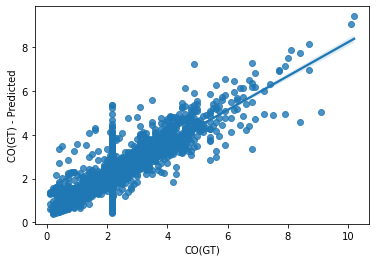

In [ ]:
y_air_quality_pred_linear = linearRegressor.predict(x_air_quality_test)
# Showing results
df_linear = pd.DataFrame(data=y_air_quality_test)
df_linear['CO(GT) - Predicted'] = y_air_quality_pred_linear
print(df_linear)
sns.regplot(x='CO(GT)', y='CO(GT) - Predicted', data=df_linear);

### Evaluate

In [ ]:
# R2 -- Quanto maior, melhor!
print("Coefficient of determination R2: ", r2_score(y_air_quality_test['CO(GT)'], y_air_quality_pred_linear))
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_air_quality_test['CO(GT)'], y_air_quality_pred_linear))
print("Mean Squared Error: ", metrics.mean_squared_error(y_air_quality_test['CO(GT)'], y_air_quality_pred_linear))
# RMSE - Quanto menor, melhor!
print("Root Mean Squared Error: ", math.sqrt(metrics.mean_squared_error(y_air_quality_test['CO(GT)'], y_air_quality_pred_linear)))

Coefficient of determination R2:  0.7703772473693936
Mean Absolute Error:  0.42905082051936166
Mean Squared Error:  0.3867704940808831
Root Mean Squared Error:  0.621908750606456


## Training, Testing and Evaluating: **Support Vector Regression**


> According to [Scikit-Learn](https://scikit-learn.org/stable/modules/svm.html#svm-regression), "*There are three different implementations of Support Vector Regression: SVR, NuSVR and LinearSVR. LinearSVR provides a faster implementation than SVR but only considers the linear kernel, while NuSVR implements a slightly different formulation than SVR and LinearSVR.*". For those reasons, we've experienced a very slow building time, due to a large amount of data, so we're using LinearSVR. In addition, we also wanted only to build a linear model, another reason to use this faster implementation.

### Training

In [ ]:
# 'make_pipeline' is a shorthand for the Pipeline constructor, which is responsible for a sequentially applying a list of transformations and a final estimator.
# So, first it performs a data normalization, and do runs a Linear SVR.
svrRegressor = make_pipeline(StandardScaler(),LinearSVR(random_state=0, tol=1e-5))

svrRegressor.fit(x_air_quality_training, y_air_quality_training)
# regressor = SVR(kernel = 'linear')
# regressor.fit(x_air_quality_training, y_air_quality_training)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linearsvr',
                 LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
                           intercept_scaling=1.0, loss='epsilon_insensitive',
                           max_iter=1000, random_state=0, tol=1e-05,
                           verbose=0))],
         verbose=False)

### Testing

        CO(GT)  CO(GT) - Predicted
3043  2.000000            2.219354
5813  0.800000            0.727788
4974  2.152743            1.543777
750   1.400000            1.117943
919   2.152743            1.733878
...        ...                 ...
3868  1.400000            1.200121
8163  1.000000            1.237876
7723  0.200000            1.239713
728   1.700000            1.300850
9055  2.400000            1.266839

[2807 rows x 2 columns]


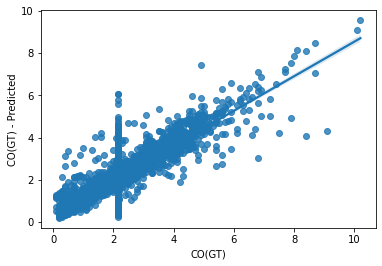

In [ ]:
y_air_quality_pred_svr = svrRegressor.predict(x_air_quality_test)
# Showing results
df_svr = pd.DataFrame(data=y_air_quality_test)
df_svr['CO(GT) - Predicted'] = y_air_quality_pred_svr
print(df_svr)
sns.regplot(x='CO(GT)', y='CO(GT) - Predicted', data=df_svr);

### Evaluating

In [ ]:
print("Coefficient of determination R2: ", r2_score(y_air_quality_test['CO(GT)'], y_air_quality_pred_svr))
print("Mean Absolute Error: ", metrics.mean_absolute_error(y_air_quality_test['CO(GT)'], y_air_quality_pred_svr))
print("Mean Squared Error: ", metrics.mean_squared_error(y_air_quality_test['CO(GT)'], y_air_quality_pred_svr))
print("Root Mean Squared Error: ", math.sqrt(metrics.mean_squared_error(y_air_quality_test['CO(GT)'], y_air_quality_pred_svr)))

Coefficient of determination R2:  0.7577963125147583
Mean Absolute Error:  0.41242067156554024
Mean Squared Error:  0.407961488152601
Root Mean Squared Error:  0.6387186298775079
